# Relatório Intermediário

Gabriella Cukier

### Bibliotecas

In [2]:
import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt

### Funções utilizadas

In [3]:
def roda_com_entrada(executavel, arquivo_in):
    with open(arquivo_in) as f:
        start = time.perf_counter()
        proc = subprocess.run([f"./exe/{executavel}"], input=f.read(), text=True, capture_output=True)
        end = time.perf_counter()
        
        return(proc.stdout, (end - start))

In [4]:
def gera_resultados(path, arquivos, executaveis):
    dic={}
    for executavel in executaveis:
        dic[executavel] = {
            "results": None,
            "times" : None
        }
        results=[]
        times=[]
        for arquivo_in in arquivos:

            desempenho = roda_com_entrada(executavel, f"{path}/{arquivo_in}")
            results.append(desempenho[0])
            times.append(desempenho[1])

        dic[executavel]["results"] = results
        dic[executavel]["times"] = times
    return dic

In [5]:
def multi_df(dic):
    # https://www.geeksforgeeks.org/nested-dictionary-to-multiindex-dataframe/
    reformed_dict = {}
    for outerKey, innerDict in dic.items():
        for innerKey, values in innerDict.items():
            reformed_dict[(outerKey,
                           innerKey)] = values

    multiIndex_df = pd.DataFrame(reformed_dict)
    return multiIndex_df

## Descrição e Objetivos

O presente projeto trabalha o problema da área de Bioinformática conhecido como alinhamento de sequências de DNA, que consiste em uma comparação entre sequências de bases nitrogenadas, de forma a encontrar seu nível de similaridade. 

Tal nível de similaridade pode ser convertido em um score numérico, com base em certos pesos atribuídos aos acertos (match) e erros (gap e mismatch). Nas implementações apresentadas a seguir, os pesos foram definidos da seguinte forma:
* Match = 2
* Mismatch = -1
* Gap = -1

O objetivo é encontrar as sequências que tenham o maior nível de similaridade, ou seja, o maior score entre elas.

Diversas estratégias foram implementadas visando a alcançar este objetivo, sendo elas:
* Solução Heurística (método de Smith Waterman)
* Busca Local com aleatoriedade
* Busca Exaustiva

A seguir, cada uma destas implementações será descrita detalhadamente e seus resultados comparados e discutidos.

## Testes 

Todas as implementações possuiam duas sequências de DNA como entradas. A saídas esperada era um score máximo de alinhamento, com as sequências correspondentes encontradas.

Para cada um dos programas descritos a seguir, as entradas para teste foram geradas por um código fornecido no enunciado, mostrado
abaixo:

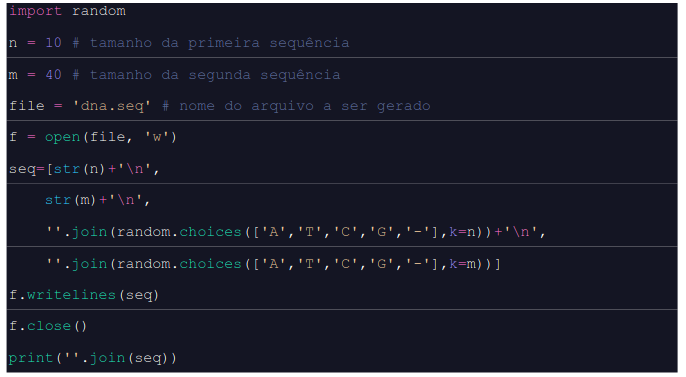

O output deste código foi salvo num arquivo chamado dna.seq, que contém o seguinte formato:


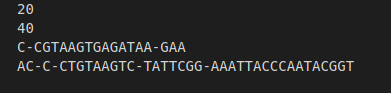

As duas primeiras linhas indicam o tamanho das sequências de entrada A e B, respectivamente. As linhas seguintes contêm as sequências correspondentes geradas.

Vários testes foram gerados em todas as etapas do projeto. Além disso, especificamente para a etapa de Smith Waterman, os resultados foram comparados aos de referência do site:
https://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Smith-Waterman

## Para rodar

Para rodar os programas, é necessário seguir os seguintes passos (dentro da pasta codigos):
1. Compilar
         g++ -Wall -O3 programa.cpp -o programa
2. Rodar, indicando entradas e saídas
         ./programa < ../inputs/dna.seq > ../outputs/programa

--------------

## Smith Waterman

A etapa inicial do projeto implementa a Heurística de Alinhamento Local de Smith-
Waterman, aplicada a duas sequências de DNA fornecidas como input, calculando o score
máximo de alinhamento entre elas. Em seguida, reconstrói o alinhamento local ótimo das
duas sequências.


### Funcionamento

A Heurística de Alinhamento Local de Smith-Waterman consiste em um algoritmo que
segue os seguintes passos:
1. Inicializa uma matriz
n x
m com as linhas e colunas na posição 0 (em ambos os
eixos) contendo o valor 0
2. Para cada 1≤i≤n e 1≤j≤m:
4. Calcula a diagonal de acordo com a seguinte fórmula:
H[i-1,j-1] + w(a[i],b[j])
onde:
 * w(a[i],b[j])=2 se houve match,
 * w(a[i],b[j])= -1 se houve mismatch e
 * w(a[i],b[j])= -1 se houve gap
 
    
5. Calcula a deleção por meio de H[i-1,j] - 1
6. Calcular a inserção por meio de H[i,j-1] - 1
7. Atribui à posição da matriz H[i,j] o máximo dentre os valores;
   * diagonal
   * deleção
   * inserção
   * 0 (de forma a nunca ser negativo)
8. Por fim, retorna o valor máximo da matriz


Durante a construção da matriz, o caminho seguido foi armazenado em um struct, de
forma que, partindo da posição do score máximo encontrado, foi possível retornar no
caminho, o que permitiu reconstruir as sequências com o melhor alinhamento possível.
Este caminho foi determinado com a seguinte correspondência:
   * deleção = salto de cima para baixo
   * inserção = salto da esquerda para a direita
   * diagonal


Desta forma, foi armazenada no struct a movimentação necessária nos eixos X e Y, de
acordo com a descrição acima, além do valor calculado para cada posição.

----------

## Busca local

Esta etapa inicial do projeto implementa a estratégia de Busca Local com Aleatoriedade,
aplicada a duas sequências de DNA fornecidas como input, calculando o score máximo de
alinhamento entre elas, por meio da divisão em subsequências. Tal estratégia de divisão
em problemas menores tem o intuito de diminuir o tempo de processamento,
principalmente para sequências muito grandes

### Funcionamento

O algoritmo funciona por meio dos seguintes passos:
1. Lê duas sequências de DNA com tamanho especificado (a - tamanho n e b - tamanho
m), contidas em um arquivo de entrada
2. Para gerar a subsequência, devemos fornecer um ponto de início da sequência original
(j) e o tamanho que esta subsequência terá (k). Estes valores foram gerados
aleatoriamente, no intervalo:
                    k, 1<=k<=m
e
                     j, 0<=j<=m-k
Por exemplo, se o tamanho sorteado da sequência de entrada AGCACACA for 3 e j=1, teríamos
a seguinte subsequência:

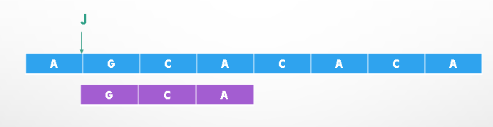

3. Gerou-se um número positivo p, correspondente ao número de subsequências da
entrada a que serão geradas para serem comparadas com sb. Neste projeto, foi
determinado que o valor de p deve ser o dobro de k, um valor
suficientemente grande para que se obtenha diversidade nas sequências aleatórias
geradas (principalmente para entradas maiores). É esperado que quanto maior o valor
de p, maior a chance de se encontrar um score melhor, porém maior o tempo de
execução. De acordo com a necessidade, os limiares de p podem ser
ajustados.
4. Foi sorteado um número i, 0<=i<=n (correspondente ao ponto de início na sequência
a) e p sequências sa com o tamanho k calculado previamente foram geradas. Estas
sequências foram armazenadas em um vetor para futura comparação de alinhamento.
5. Percorrendo o vetor das subsequências sa armazenadas, foram comparadas as bases
nitrogenadas em cada posição com a posição correspondente da subsequência sb. Os
scores de cada par (sa,sb) foram calculados com os pesos wmat=2, wmis=-1 e wgap=-1
6. O score máximo do cálculo do passo anterior e as subsequências correspondentes a ele
foram armazenados e retornados pela função
7. Para melhorar o valor máximo de score encontrado, o algoritmo foi rodado múltiplas
vezes (1000). Tal valor escolhido arbitrariamente segue a mesma lógica de p, ou seja,
quanto maior, maior a chance de se encontrar um score melhor, porém maior o tempo
de execução.

------------

## Busca Exaustiva

### Metodologia

Esta etapa do projeto utilizou a estratégia de Busca Exaustiva, em que uma solução ótima de um problema é encontrada, por meio da geração de todas as soluções possíveis.

Sendo uma entrada composta por duas sequências de DNA (A e B), o código implementado funciona por meio das seguintes etapas:

1. Geração de todas as subsequências de A e de B
2. Cálculo dos alinhamentos de cada par de subsequencias de A e de B (com os pesos wmat, wmis e wgap). Foram utilizadas as seguintes estratégias para o cálculo:

    2.1. Alinhamento pelo método de Smith Waterman

    2.2. Score simples, por meio de uma comparação direta entre as duas subsequências, sendo a maior truncada para que ambas possuam o mesmo tamanho
    
    2.3. Uma mistura das duas estratégias descritas acima, sendo o score simples utilizado no cálculo de quando as sequências possuem o mesmo tamanho e o método de Smith Waterman, caso contrário.


3. A saída do programa será composta do score de alinhamento, além das subsequências correspondentes alinhadas.

----------

## Resultados: Smith Waterman e Busca Local

Para os testes, foram testadas 16 sequências diversas geradas aleatoriamente pelo programa em python (descrito na sessão de testes), de tamanho n=m variável, com valores entre 10 até 860,
incrementados com intervalos de 50. 

Os resultados e os tempos de execução de cada programa foram salvos em dataframes e seus resultados analisados

In [11]:
executaveis = ["smith_waterman_melhorado","busca-local-melhorada"]
arquivos=[]
for i in range(17):
    arquivos.append(f"dna{i}.seq")

##### Criando  Dataframes

In [12]:
dic = gera_resultados("in", arquivos, executaveis)

In [13]:
df = pd.DataFrame(dic)
df

,smith_waterman_melhorado,busca-local-melhorada
results,"[7, 37, 52, 94, 118, 153, 184, 197, 235, 282, ...","[5, 17, 10, 16, 15, 14, 13, 13, 12, 14, 13, 12..."
times,"[0.01037151599985009, 0.0062331799999810755, 0...","[0.007617633999871032, 0.06311329300024227, 0...."


In [14]:
multiIndex_df = pd.DataFrame(multi_df(dic))
multiIndex_df

smith_waterman_melhorado           busca-local-melhorada           
                    results     times               results      times
0                         7  0.010372                     5   0.007618
1                        37  0.006233                    17   0.063113
2                        52  0.005477                    10   0.191437
3                        94  0.004850                    16   0.435853
4                       118  0.005002                    15   0.785666
5                       153  0.005834                    14   1.125449
6                       184  0.006688                    13   1.706621
7                       197  0.008724                    13   2.501877
8                       235  0.007331                    12   2.914983
9                       282  0.008699                    14   3.957514
10                      313  0.009644                    13   4.708684
11                      316  0.010152                    12   5.728756
12                      333  0.011592                    20   6.862335
13                      396  0.012719                    13   8.134949
14                      407  0.014227                    19   9.855676
15                      439  0.015624                    17  11.408586
16                      488  0.016946                    14  12.668643

#### Gráfico do tempo em função do tamanho da sequência

Text(0, 0.5, 'tempo')

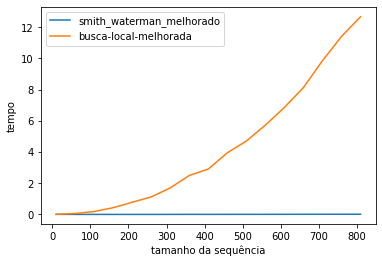

In [15]:
valores=[10]
for i in range (1,17):
    valores.append(valores[i-1]+50)
    
for exe in df.columns.values.tolist():
    plt.plot(valores,multiIndex_df[exe]["times"].values.astype(float), label=exe)
plt.legend()
plt.xlabel("tamanho da sequência")
plt.ylabel("tempo")

##### Ampliação do gráfico de Smith Waterman

No handles with labels found to put in legend.


Text(0, 0.5, 'tempo')

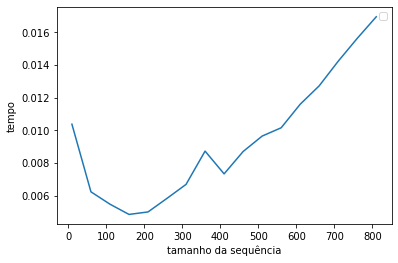

In [16]:
plt.plot(valores,multiIndex_df["smith_waterman_melhorado"]["times"].values.astype(float))
plt.legend()
plt.xlabel("tamanho da sequência")
plt.ylabel("tempo")

#### Gráfico dos resultados em função do tamanho da sequência

Text(0, 0.5, 'valor máximo')

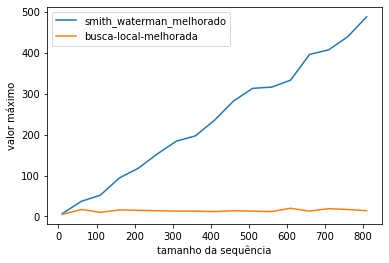

In [18]:
for exe in df.columns.values.tolist():
    plt.plot(valores,multiIndex_df[exe]["results"].values.astype(float), label=exe)
plt.legend()
plt.xlabel("tamanho da sequência")
plt.ylabel("valor máximo")

##### Ampliação do gráfico da busca local

No handles with labels found to put in legend.


Text(0, 0.5, 'valor máximo')

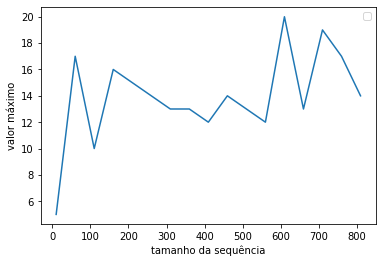

In [20]:
plt.plot(valores,multiIndex_df["busca-local-melhorada"]["results"].values.astype(float))
plt.legend()
plt.xlabel("tamanho da sequência")
plt.ylabel("valor máximo")

Tanto no gráfico do tempo, quanto no dos resultados, ambos em em função do tamanho da sequência, o algoritmo de Smith Waterman aparentou obter um desempenho melhor, com resultados mais desejados em relação ao tempo e aos valores.

Uma possível explicação é que como o algoritmo de busca local roda o programa inúmeras vezes, de forma a atingir um maior nível de aleatoriedade e testar mais sequências, ele tende a demorar mais.

Ademais, os testes mostraram que no programa de busca local, um alto valor de p favoreceu um desempenho melhor dos resultados, já que permitiu que
múltiplas sequências fossem testadas, procurando assim as que melhor se alinhavam.
Contudo, o valor de k, correspondente ao tamanho das subsequências, por ser pequeno, ainda foi um limitante
para o score máximo.

Outro fator limitante desta implementação foi que, como ela não considera os gaps de alinhamento, como a de Smith Waterman, o score final tende a ser menor.

## Resultados: Busca Exaustiva

#### Metodologia da comparação

Como a estratégia da busca exaustiva consiste em testar todas as possibilidades possíveis e assim achar uma solução ótima global, ela tende a ser mais compuacionalmente custosa. Desta forma, para fins de teste de desempenho, foi utilizado um intervalo com valores mais baixos referentes ao tamanho da sequência.

Para comparar os desempenhos entre as implementações descritas anteriormente, foram criadas 10 entradas diferentes, com o valor inicial do tamanho da sequência começando em 1 e aumentando de 10 em 10.

Os respectivos resultados de cada programa foram salvos em um dataframe, assim como os tempos de execução correspondentes. Por fim, foram elaborados gráficos comparativos e seus resultados analisados

##### Rodando os executáveis com cada arquivo de entrada

In [21]:
executaveis = ["busca_exaustiva","busca_exaustiva_score_simples","busca_exaustiva_smith_waterman"]
arquivos=[]
for i in range(10):
    arquivos.append(f"dna{i}.seq")

##### Criando um Dataframe

In [22]:
dic = gera_resultados("in_exaustiva", arquivos, executaveis)

In [23]:
df = pd.DataFrame(dic)
df

,busca_exaustiva,busca_exaustiva_score_simples,busca_exaustiva_smith_waterman
results,"[0, 6, 13, 18, 28, 27, 35, 43, 42, 56]","[0, 5, 7, 11, 16, 16, 13, 15, 13, 12]","[0, 6, 13, 18, 28, 27, 35, 43, 42, 56]"
times,"[0.006169245999899431, 0.008238679999976739, 0...","[0.004207554000004166, 0.005369520999920496, 0...","[0.004588417999912053, 0.006160468999951263, 0..."


In [24]:
multiIndex_df = pd.DataFrame(multi_df(dic))
multiIndex_df

busca_exaustiva             busca_exaustiva_score_simples             \
          results       times                       results      times   
0               0    0.006169                             0   0.004208   
1               6    0.008239                             5   0.005370   
2              13    0.067508                             7   0.015806   
3              18    0.568779                            11   0.070952   
4              28    2.499361                            16   0.239958   
5              27    8.837867                            16   0.693849   
6              35   27.235543                            13   1.610051   
7              43   67.351780                            15   3.459035   
8              42  141.945576                            13   6.948416   
9              56  282.428953                            12  13.511042   

  busca_exaustiva_smith_waterman              
                         results       times  
0                              0    0.004588  
1                              6    0.006160  
2                             13    0.070085  
3                             18    0.585217  
4                             28    2.658241  
5                             27    9.266643  
6                             35   27.908462  
7                             43   60.005749  
8                             42  138.979629  
9                             56  279.634137

##### Gráfico da comparação de tempo

Text(0.5, 1.0, 'Gráfico do tempo em função do tamanho da sequência\n')

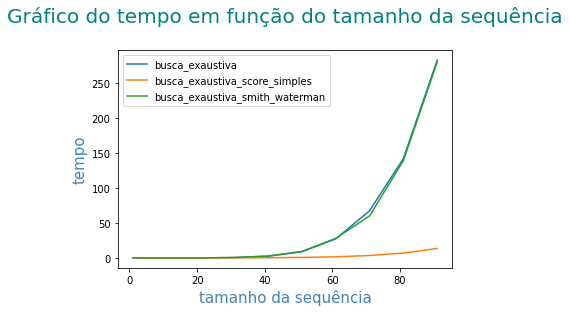

In [25]:
valores=[1]
for i in range (1,10):
    valores.append(valores[i-1]+10)

for exe in df.columns.values.tolist():
    plt.plot(valores,multiIndex_df[exe]["times"].values, label=exe)
plt.legend()
plt.xlabel("tamanho da sequência", 
           fontsize=15,
          color="steelblue")
plt.ylabel("tempo", 
           fontsize=15,
          color="steelblue")
plt.title(label="Gráfico do tempo em função do tamanho da sequência\n",
          fontsize=20,
          color="teal")

##### Gráfico da comparação de valores

Text(0.5, 1.0, 'Gráfico do valor máximo encontrado em função do tamanho da sequência\n')

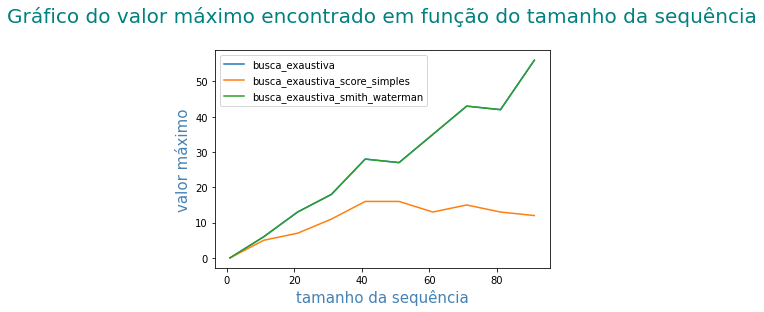

In [26]:
for exe in df.columns.values.tolist():
    plt.plot(valores,multiIndex_df[exe]["results"].values.astype(float), label=exe)
plt.legend()
plt.xlabel("tamanho da sequência", 
           fontsize=15,
          color="steelblue")
plt.ylabel("valor máximo", 
           fontsize=15,
          color="steelblue")
plt.title(label="Gráfico do valor máximo encontrado em função do tamanho da sequência\n",
          fontsize=20,
          color="teal")

### Análise e conclusões

O gráfico do tempo em função do tamanho da sequência mostrou que o desempenho da busca exaustiva com o alinhamento calculado pelo método de Smith Waterman teve um desempenho muito similar em termos de velocidade ao método que mesclava Smith Waterman com o cálculo de score simples. Ambos aparentam possuir complexidade O(n²), apresentando uma curva exponencial

Este resultado condiz com o esperado, pois gerar todas as subsequências possíveis é de fato algo muito custoso. Além disso, ao calcular os scores de tais subsequências, na maior parte das comparações, o tamanho entre as elas será diferente, de forma que na realidade a maior parte dos cálculos se dará pelo próprio método de Smith Waterman. 

Por precisar montar uma matriz e calcular o score em cada posição com dependência dos valores das posições vizinhas, este método é de fato demorado. Além disso, ele inclui a reconstrução do alinhamento das sequências, em que um caminho dentro da matriz deve ser percorrido novamente. O processo como um todo é bem mais complexo do que uma comparação simples, feita a partir de uma mesma posição em duas sequências distintas, o que consequentemente eleva significativamente o tempo de processamento.

Além disso, é possível observar que existe um limiar em torno do tamanho da sequência igual a 40, a partir do qual o tempo de processamento dos programas com o uso do método de Smith Waterman cresce mais.

Ou seja, a partir de tal limiar, a utilização de tais métodos pode apresentar desvantagens em relação ao tempo de processamento, sendo que quanto maior o tamanho da sequência, pior será o desempenho.

Contudo, estes métodos apresentaram vantagens em relação ao desempenho, como mostra o gráfico do valor máximo encontrado em função do tamanho da sequência.

Para tamanhos de sequência menores (cerca de abaixo de 10), os resultados do alinhamento calculado por Smith Waterman e pelo método de alinhamento simples não diferiram significativamente. Porém, conforme o tamanho da sequência aumenta, o gráfico mostra que o cálculo por score simples possui um desempenho nitidamente inferior. Isso se dá pelo fato deste método não considerar os gaps no alinhamento, conforme é calculado no método de Smith Waterman.

## Comparação entre todos os algoritmos implementados

Para que fosse possível obter uma visão geral comparativa entre todas as implementações desenvolvidas, foi utilizado o range com valores mais baixos. Os resultados são apresentados a seguir:


In [27]:
executaveis = ["smith_waterman_melhorado","busca-local-melhorada", "busca_exaustiva","busca_exaustiva_score_simples","busca_exaustiva_smith_waterman"]
arquivos=[]
for i in range(10):
    arquivos.append(f"dna{i}.seq")

##### Criando  Dataframes

In [28]:
dic = gera_resultados("in_exaustiva", arquivos, executaveis)

In [29]:
df = pd.DataFrame(dic)
df

,smith_waterman_melhorado,busca-local-melhorada,busca_exaustiva,busca_exaustiva_score_simples,busca_exaustiva_smith_waterman
results,"[0, 6, 13, 18, 28, 27, 35, 43, 42, 56]","[0, 5, 7, 11, 16, 15, 13, 12, 12, 10]","[0, 6, 13, 18, 28, 27, 35, 43, 42, 56]","[0, 5, 7, 11, 16, 16, 13, 15, 13, 12]","[0, 6, 13, 18, 28, 27, 35, 43, 42, 56]"
times,"[0.011053974999867933, 0.006364657000176521, 0...","[0.005083661999833566, 0.00806276599996636, 0....","[0.00477432499974384, 0.005777719999969122, 0....","[0.004441843000222434, 0.0051698520001082215, ...","[0.004381418000320991, 0.005808379999962199, 0..."


In [30]:
multiIndex_df = pd.DataFrame(multi_df(dic))
multiIndex_df

smith_waterman_melhorado           busca-local-melhorada            \
                   results     times               results     times   
0                        0  0.011054                     0  0.005084   
1                        6  0.006365                     5  0.008063   
2                       13  0.005148                     7  0.016014   
3                       18  0.006220                    11  0.023799   
4                       28  0.004668                    16  0.035784   
5                       27  0.004777                    15  0.048253   
6                       35  0.006087                    13  0.066046   
7                       43  0.004620                    12  0.091192   
8                       42  0.003761                    12  0.112926   
9                       56  0.005142                    10  0.142749   

  busca_exaustiva             busca_exaustiva_score_simples             \
          results       times                       results      times   
0               0    0.004774                             0   0.004442   
1               6    0.005778                             5   0.005170   
2              13    0.066776                             7   0.015442   
3              18    0.515048                            11   0.068194   
4              28    2.526296                            16   0.247917   
5              27    8.523447                            16   0.648077   
6              35   23.748463                            13   1.576342   
7              43   61.210544                            15   3.359443   
8              42  127.459471                            13   6.773197   
9              56  258.564934                            12  12.159647   

  busca_exaustiva_smith_waterman              
                         results       times  
0                              0    0.004381  
1                              6    0.005808  
2                             13    0.065247  
3                             18    0.510004  
4                             28    2.446354  
5                             27    8.704253  
6                             35   24.026237  
7                             43   61.211519  
8                             42  129.385607  
9                             56  261.942245

##### Gráfico da comparação de tempo

Text(0.5, 1.0, 'Gráfico do tempo em função do tamanho da sequência\n')

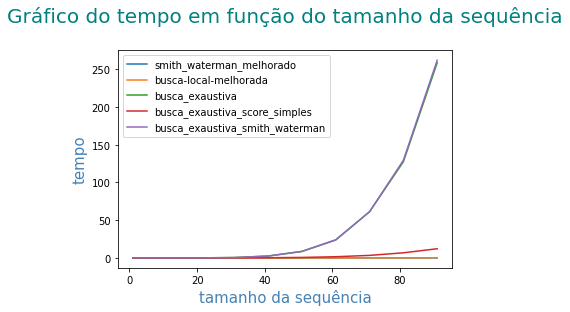

In [31]:
valores=[1]
for i in range (1,10):
    valores.append(valores[i-1]+10)

for exe in df.columns.values.tolist():
    plt.plot(valores,multiIndex_df[exe]["times"].values, label=exe)
plt.legend()
plt.xlabel("tamanho da sequência", 
           fontsize=15,
          color="steelblue")
plt.ylabel("tempo", 
           fontsize=15,
          color="steelblue")
plt.title(label="Gráfico do tempo em função do tamanho da sequência\n",
          fontsize=20,
          color="teal")

##### Gráfico da comparação de valores

Text(0.5, 1.0, 'Gráfico do valor máximo encontrado em função do tamanho da sequência\n')

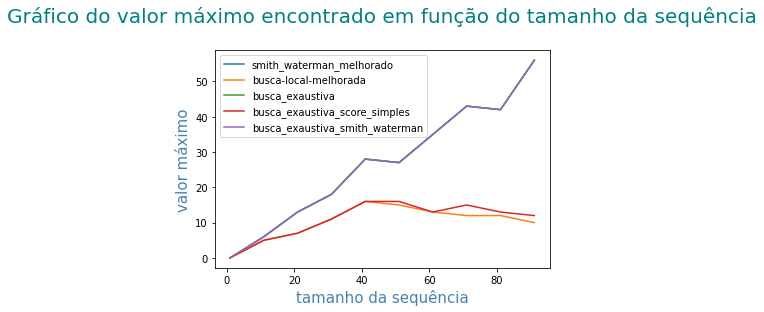

In [32]:
for exe in df.columns.values.tolist():
    plt.plot(valores,multiIndex_df[exe]["results"].values.astype(float), label=exe)
plt.legend()
plt.xlabel("tamanho da sequência", 
           fontsize=15,
          color="steelblue")
plt.ylabel("valor máximo", 
           fontsize=15,
          color="steelblue")
plt.title(label="Gráfico do valor máximo encontrado em função do tamanho da sequência\n",
          fontsize=20,
          color="teal")

### Análise e conclusões

Os gráficos mostraram que as estratégias exaustivas obteram os melhores scores, principalmente aquelas que utilizam a estratégia de Smith Waterman e, portanto, consideraram os Gaps no cálculo. Contudo, essas mesmas estratégias tiveram um desempenho bastante pior em termos de tempo.

Além disso, a estratégia de busca exaustiva por score simples teve um desempenho bastante semelhante àquelas implementadas anteriormente, nas duas primeiras partes do projeto.

## Comparação relativa de tempos

Para se ter uma visão geral mais clara em relação aos tempos de execução, foram plotados gráficos comparativos deste parâmetro específico, mostrados abaixo:

In [33]:
df_times = multiIndex_df.xs('times', level=1, axis=1)

In [34]:
df_times.index = valores
df_times

,smith_waterman_melhorado,busca-local-melhorada,busca_exaustiva,busca_exaustiva_score_simples,busca_exaustiva_smith_waterman
1,0.011054,0.005084,0.004774,0.004442,0.004381
11,0.006365,0.008063,0.005778,0.005170,0.005808
21,0.005148,0.016014,0.066776,0.015442,0.065247
31,0.006220,0.023799,0.515048,0.068194,0.510004
41,0.004668,0.035784,2.526296,0.247917,2.446354
51,0.004777,0.048253,8.523447,0.648077,8.704253
61,0.006087,0.066046,23.748463,1.576342,24.026237
71,0.004620,0.091192,61.210544,3.359443,61.211519
81,0.003761,0.112926,127.459471,6.773197,129.385607
91,0.005142,0.142749,258.564934,12.159647,261.942245


<AxesSubplot:>

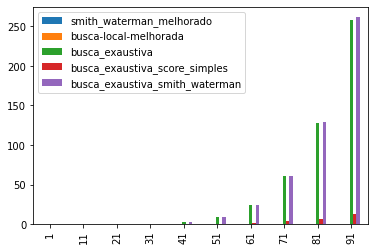

In [35]:
ax = df_times.plot.bar()
ax

Nesta perspectiva fica clara a escala de o quanto mais lenta foi a busca exaustiva. As outras estratégias ficam quase invisíveis em termos de escala. Além disso, é possível perceber a como os valores da demora para rodar crescem muito rapidamente nestes casos, o que condiz com sua complexidade quadrática.

Para se obter uma visão comparativa mais direta entre as proporções de tempo que cada estratégia implementada leva em relação às outras, cada valor obtido de tempo foi dividido pelo menor obtido. Desta forma, é possível realizar uma análise comparativa com valores relativos.

In [36]:
df_times/df_times.values.min()

,smith_waterman_melhorado,busca-local-melhorada,busca_exaustiva,busca_exaustiva_score_simples,busca_exaustiva_smith_waterman
1,2.939306,1.351771,1.269516,1.181108,1.165041
11,1.692393,2.143929,1.536324,1.374689,1.544477
21,1.368901,4.258180,17.756013,4.106046,17.349448
31,1.653933,6.328287,136.953711,18.133135,135.612511
41,1.241198,9.515239,671.754362,65.922449,650.497501
51,1.270280,12.830655,2266.426447,172.326935,2314.503595
61,1.618554,17.562074,6314.832757,419.157173,6388.694203
71,1.228476,24.248470,16276.183851,893.292236,16276.443002
81,1.000000,30.027653,33892.098289,1801.026319,34404.267210
91,1.367231,37.957539,68753.683558,3233.309761,69651.727153


Os resultados mostraram que o algoritmo com melhor desempenho em termos de velocidade foi o de Smith Waterman.
A implementação de busca local também teve resultados que podem ser considerados bons, com a proporção máxima sendo cerca de 2.8 vezes mais lento na maior entrada, em comparação com a implementação mais rápida.

A busca exaustiva de score simples chegou a ter um desempenho quase 30 mil vezes pior em termos de tempo em relação ao mais rápido com uma entrada de tamanho 91.

Contudo, os piores resultados foram claramente aqueles da busca exaustiva, tanto com a utilização da estratégia conjunta quanto de Smith Waterman. Com uma entrada de tamanho 91, o resultado obtido foi quase 60 mil vezes pior do que a implementação mais rápida.

É importante também ressaltar que para valores de tamanho de entrada pequenhos, até cerca de 11, os valores de tempo foram parecidos em todas as implementações. Porém, conforme os valores do tamanho da entrada sobem, a diferença cresce muito rapidamente.

Os gráficos a ilustram mostram essa relação:

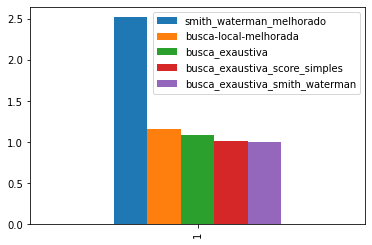

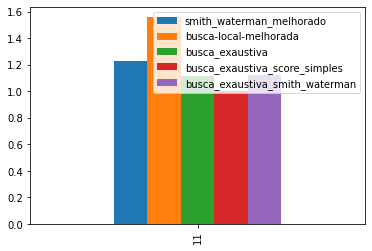

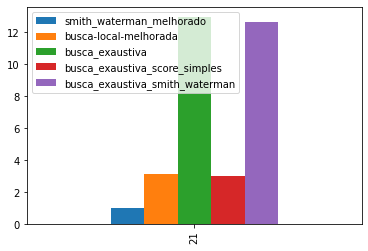

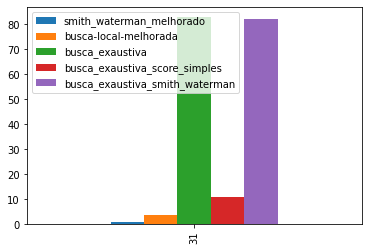

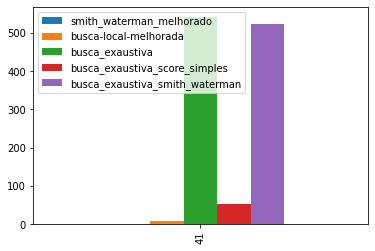

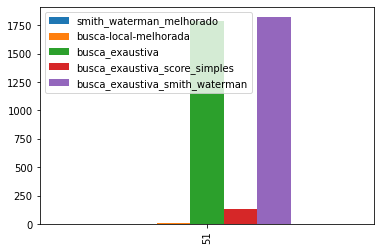

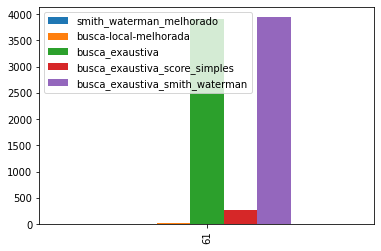

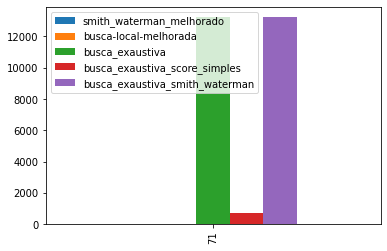

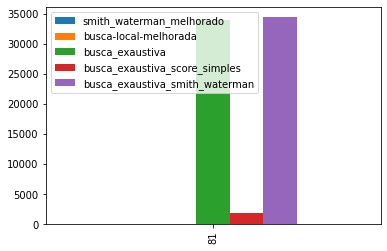

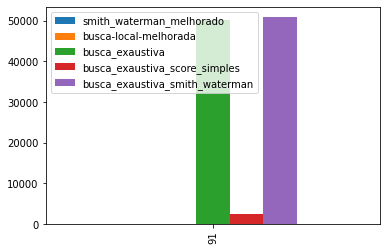

In [37]:
for i in range(10):
        (df_times.iloc[[i]]/df_times.iloc[[i]].values.min()).plot.bar()

# Profiling

### Metodologia

Para identificar os principais pontos que poderiam ser aprimorados nos códigos, foi usada a ferramenta Valgrind.
Para isso, foram utilizados os seguintes comandos:

                g++ -Wall -O3 -g programa.cpp -o programa
                valgrind --tool=callgrind ./programa
                callgrind_annotate callgrind.out.NUM programa.cpp 

### Resultados

##### Smith Waterman

Alguns pontos de possíveis melhorias foram mostrados em diferentes códigos:

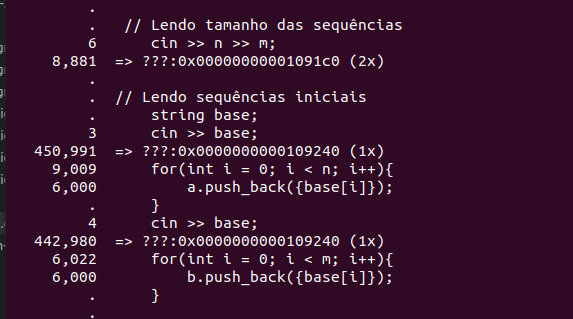

A leitura das bases nitrogenadas e cópia de cada caractere para um vetor de strings foi indicada como uma operação custosa. Uma forma de evitar isso seria ler tais valores diretamente como uma string, sem copiá-los para um vetor

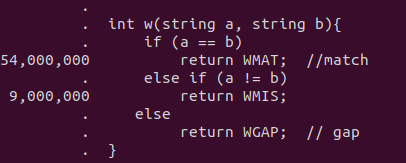

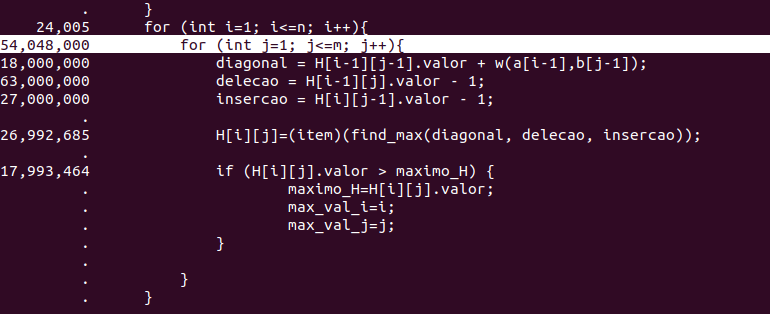

Outra indicação foram as a funções utilizadas na composição da matriz de Smith Waterman. Esta parte dos códigos é realmente muito custosa, já que cria uma grande estrutura de dados (matriz H). 

##### Busca Local

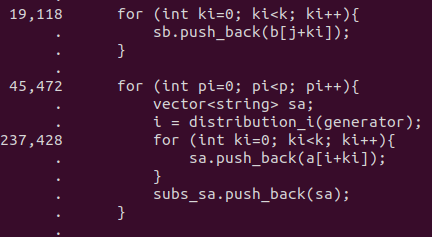

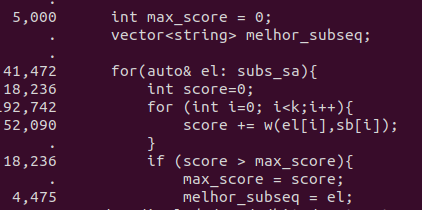

No caso da busca local, um trecho que foi um motivo importante para lentidão foi a criação da matriz com todas as subsequências de A.

Além disso, o cálculo do score também foi muito custoso por também possuir um for duplo.

Uma possível ideia seria combinar os dois trechos, retirando assim a necessidade de repetir o loop com outro interno, de forma a otimizar o programa.

##### Busca Exaustiva

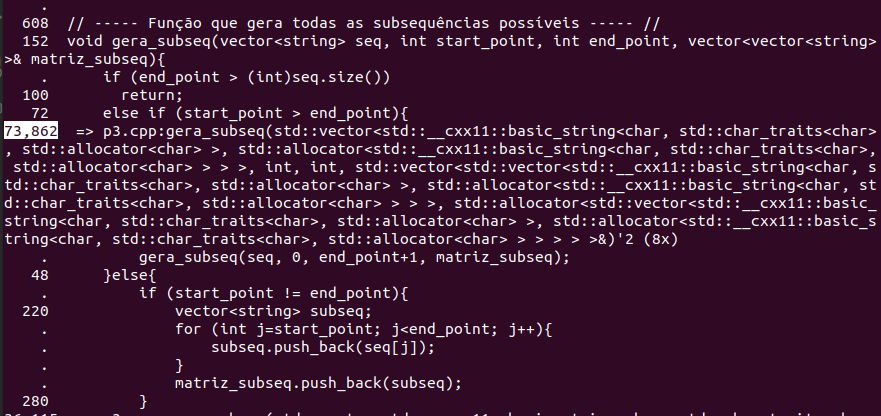

Conforme esperado, um ponto importante de dalays no código foi a geração de todas as subsequências. 

Este ponto poderia ser melhorado  por meio da implementação da estratégia de Branch and Bound.

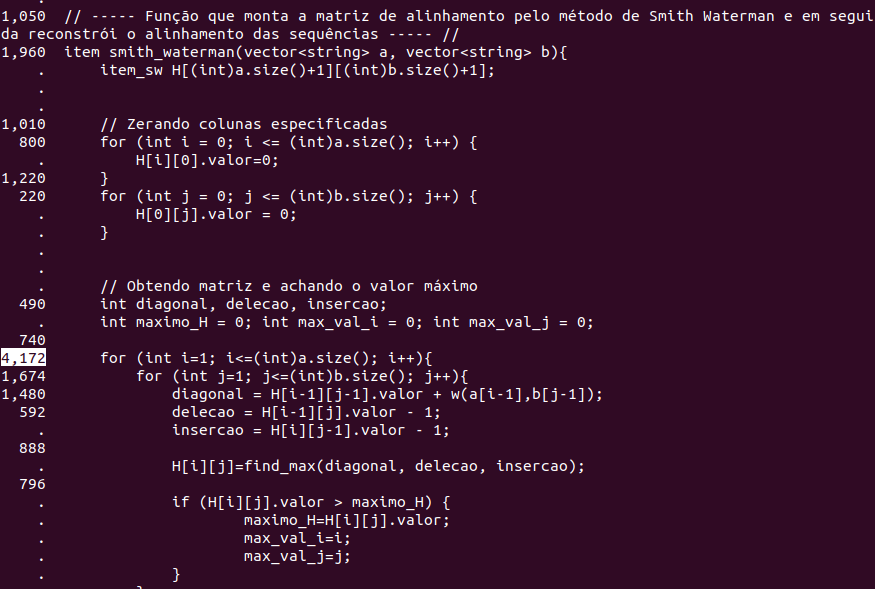

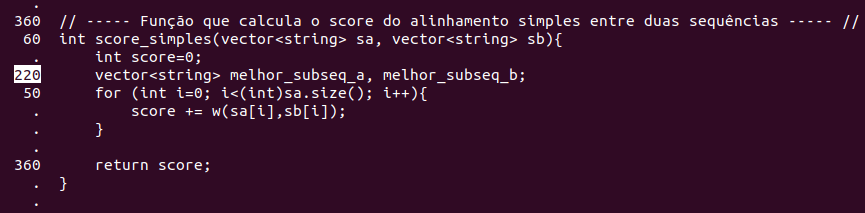

O cálculo de scores pelo método do Smith Waterman também teve alto custo computacional, conforme mostrado na análise da primeira parte do projeto.

Além disso, é interessante notar que na busca exaustiva com o cálculo de score misto (com o visto acima), o score simples é rodado muito menos vezes, já que na maior parte das vezes os tamanhos das sequências são diferentes.

# Principais pontos de lentidão identificados

##### Smith Waterman

O trecho mais custoso computacionalmente consiste na construção da matriz de structs, que é uma grande estrutura de dados que aumenta de forma significativa conforme o tamanho das sequências aumentam.

Uma boa estratégia neste caso seria dividir a sequência originam em subsequências menores, somando o score total no final. A utilização de programação paralela também poderia ser extremamente benéfica neste caso.

##### Busca Local

O principal ponto que aparenta ter causado lentidão nesta estratégia foi o fato de o programa ser rodado diversas vezes (valor definido como 1000), com o intuito de gerar diversos valores diferentes de p e k e assim testar mais sequências, aumentando as chances de encontrar um score melhor. 

Diminuindo tal valor, é esperado que o tempo de execução caia também.

Desta forma, este valor deve ser ajustado conforme as necessidades de uso, se deseja-se favorecer o desempenho ou o tempo de execução.

Formas de melhorar o desempenho poderiam incluir uma checagem se os valores de k já foram sorteados ou até mesmo se o maior score possível para o tamanho daquela sequência sorteado seria menor do que aquele já encontrado.

Outra ideia seria realizar uma checagem se o valor máximo encontrado aparenta se estabilizar e no caso positivo, encerrar a execução do programa.

##### Busca Exaustiva

Um ponto de lentidão muito importante nesta estratégia consiste na geração de todas as possíveis sequências para calcular o score.

Uma maneira possível de mitigar tal demora seria implementar uma estratégia de Branch and Bound. Por exemplo, poderia ser executada uma checagem se o score máximo de uma determinada sequência em função do seu tamanho poderia ser maior do que o score máximo atual. Caso contrário, a função retornaria, economizando assim tempo de processamento.

# Conclusões

As análises mostraram que aquelas implementações com melhores resultados de score foram as mesmas com os piores desempenhos em relação ao tempo. Desta forma, é importante considerar quais os objetivos de cada aplicação específica, de forma a possibilitar a escolha mais adequada para a metodologia de implementação, visando a favorecer determinado aspecto em relação a outro.

É importante ressaltar, porém, que algumas estratégias, como as de busca exaustiva, como implementadas no momento atual, não são adequadas para tamanhos de sequências muito grandes.

Possíveis melhorias e implementações futuras podem resolver este problema. 

Por exemplo, a estratégia de Branch and Bound pode ser útil de forma a diminuir a quantidade de sequências possíveis geradas, eliminando aquelas que não têm o potencial de gerar scores melhores.

Um ponto muito importante notado foi que sequências menores de fato diminuem significativamente o tempo de execução. Uma boa estratégia, portanto, seria dividir a sequência maior em trechos menores e calcular os scores individualmente, por fim somando os resultados. 

Neste cenário, a utilização de paralelismo poderia ser extremamente benéfica.